## Electricity price prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


In [2]:
df_data = pd.read_csv('full_diff_data_2016_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data.set_index('time_stamp', inplace = True)

In [3]:
df_data.shape

(17520, 10)

In [4]:
df_data.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff'],
      dtype='object')

In [5]:
def train_test_ts_split(X, y, percentage=0.9):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    #X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [6]:
# Standardize inputs
# scaler_price = preprocessing.StandardScaler().fit(df_data.price.values.reshape(-1, 1))
# scaler_load = preprocessing.StandardScaler().fit(df_data.load.values.reshape(-1, 1))
# scaler_temp = preprocessing.StandardScaler().fit(df_data.temp.values.reshape(-1, 1))
# df_data.loc[:,'price_norm'] = scaler_price.transform(df_data.price.values.reshape(-1, 1))
# df_data.loc[:,'load_norm'] = scaler_load.transform(df_data.load.values.reshape(-1, 1))
# df_data.loc[:,'temp_norm'] = scaler_temp.transform(df_data.temp.values.reshape(-1, 1))

scaler_price = preprocessing.MinMaxScaler().fit(df_data.price_diff.values.reshape(-1, 1))
scaler_load = preprocessing.MinMaxScaler().fit(df_data.load_diff.values.reshape(-1, 1))
scaler_temp = preprocessing.MinMaxScaler().fit(df_data.temp_diff.values.reshape(-1, 1))
df_data.loc[:,'price_diff_norm'] = scaler_price.transform(df_data.price_diff.values.reshape(-1, 1))
df_data.loc[:,'load_diff_norm'] = scaler_load.transform(df_data.load_diff.values.reshape(-1, 1))
df_data.loc[:,'temp_diff_norm'] = scaler_temp.transform(df_data.temp_diff.values.reshape(-1, 1))

In [7]:
WINDOW = 24 * 7 - 1
EMB_SIZE = 3
STEP = 1
FORECAST = 0

X, Y = [], []
for i in range(0, df_data.shape[0], STEP): 
    try:
        price_byweek = df_data.price_diff_norm.values[i: i + WINDOW]
        load_byweek = df_data.load_diff_norm.values[i: i + WINDOW]
        temp_byweek = df_data.temp_diff_norm.values[i: i + WINDOW]

        x_i = np.column_stack((price_byweek, load_byweek, temp_byweek))
        # target doesn't have to be standardized
        y_i = df_data.price_diff.values[i + WINDOW + FORECAST]
    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

In [8]:
X.shape, Y.shape

((17353, 167, 3), (17353,))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage = 0.9)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15617, 167, 3), (1736, 167, 3), (15617,), (1736,))

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15617, 167, 3), (1736, 167, 3), (15617,), (1736,))

In [11]:
bestmodel_name = 'best_weights_' + str(FORECAST) + '.hdf5'
checkpointer = ModelCheckpoint(filepath = bestmodel_name, 
                               verbose=1, save_best_only=True)

In [12]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=32,
                        filter_length=24,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Convolution1D(nb_filter=16,
                        filter_length=2,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', 
              loss='mse')
history = model.fit(X_train, Y_train, 
          nb_epoch = 20, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.2,
          shuffle=True,
          callbacks=[checkpointer])

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", filters=32, input_shape=(167, 3), kernel_size=24)`
  """
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", filters=16, kernel_size=2)`
  del sys.path[0]
/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 12493 samples, validate on 3124 samples
Epoch 1/20
12493/12493 [==============================] - 12s 976us/step - loss: 1135.1069 - val_loss: 643.4041
Epoch 2/20
12493/12493 [==============================] - 12s 952us/step - loss: 1104.6079 - val_loss: 634.8418
Epoch 3/20
12493/12493 [==============================] - 11s 867us/step - loss: 1072.4497 - val_loss: 1053.1292
Epoch 4/20
12493/12493 [==============================] - 11s 871us/step - loss: 1034.5077 - val_loss: 987.3926
Epoch 5/20
12493/12493 [==============================] - 11s 862us/step - loss: 991.5896 - val_loss: 953.7239
Epoch 6/20
12493/12493 [==============================] - 11s 874us/step - loss: 924.3941 - val_loss: 942.2059
Epoch 7/20
12493/12493 [==============================] - 11s 894us/step - loss: 904.8120 - val_loss: 479.3581
Epoch 8/20
12493/12493 [==============================] - 11s 900us/step - loss: 825.1566 - val_loss: 846.1038
Epoch 9/20
12493/12493 [==============================] - 

In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 167, 32)           2336      
_________________________________________________________________
batch_normalization_1 (Batch (None, 167, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 167, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 83, 16)            1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 83, 16)            64        
_________________________________________________________________
activation_2 (Activation)    (None, 83, 16)            0         
__________

In [20]:
# model.save('model.h5')
model.load_weights('best_weights_' + str(FORECAST) + '.hdf5')
pred = model.predict(np.array(X_test))

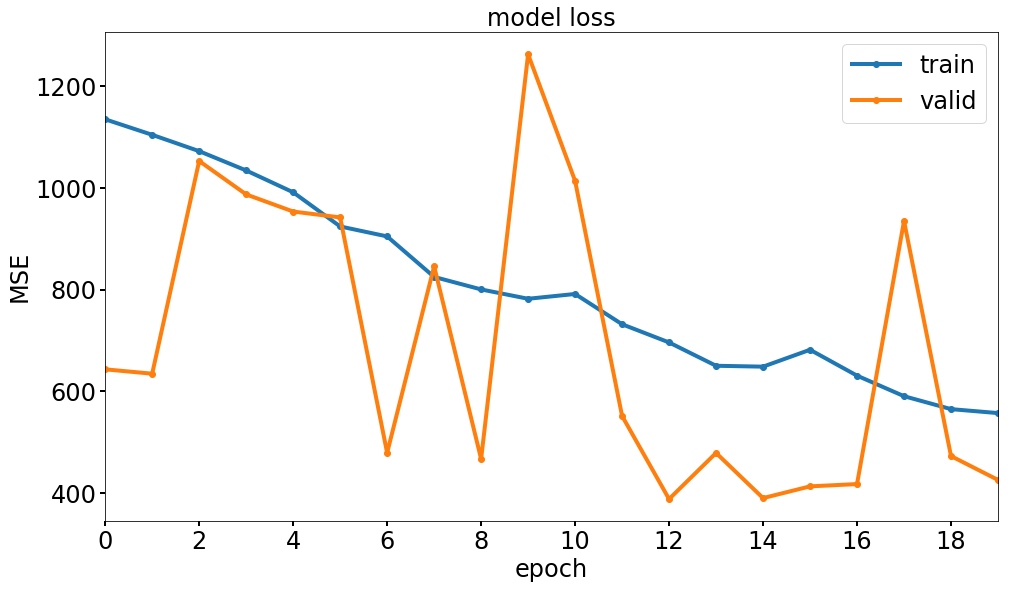

In [57]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(history.history['loss'], 'o-', linewidth = 4)
ax.plot(history.history['val_loss'], 'o-', linewidth = 4)
ax.set_title('model loss', fontsize = 24)
ax.set_ylabel('MSE', fontsize = 24)
ax.set_xlabel('epoch', fontsize = 24)
ax.set_xlim(0, 19)
ax.legend(['train', 'valid'], loc='best', fontsize = 24)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
new_tick_locs = range(0,20,2);
new_tick_labels = range(0,20,2);
ax.set_xticks(new_tick_locs);
ax.set_xticklabels(new_tick_labels);

# ax.show()

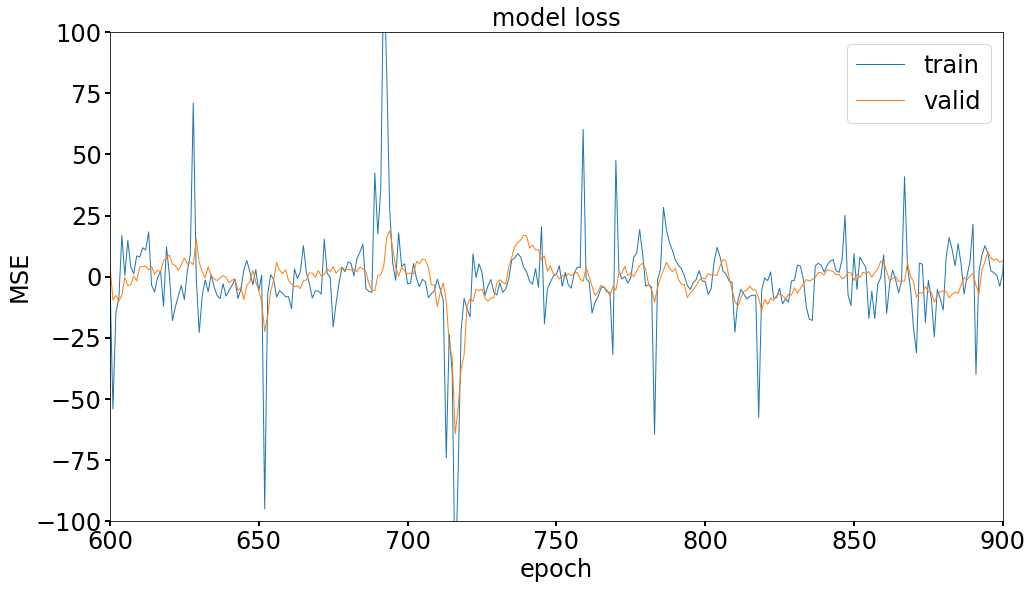

In [51]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(Y_test, linewidth = 1)
ax.plot(pred, linewidth = 1)
ax.set_title('model loss', fontsize = 24)
ax.set_ylabel('MSE', fontsize = 24)
ax.set_xlabel('epoch', fontsize = 24)
ax.set_ylim(-100, 100)
ax.set_xlim(600, 900)
ax.legend(['train', 'valid'], loc='best', fontsize = 24)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
# ax.show()

In [52]:
# np.sqrt(metrics.mean_squared_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred)))
np.sqrt(metrics.mean_squared_error(Y_test.ravel(), pred.ravel()))

25.277357811348555

In [53]:
pred[-1]

array([ 1.54035103], dtype=float32)

In [54]:
# metrics.mean_absolute_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred))
np.sqrt(metrics.mean_absolute_error(Y_test.ravel(), pred.ravel()))

3.682641120833309

In [55]:
df_hist = pd.DataFrame.from_dict(history.history)
df_hist.to_csv('history_' + str(FORECAST) + '.csv', index = False)